# Task Decomposition

Task decomposition is the strategic process of dividing complex problem into a
list of manageable subproblems


1. Complex Problem Solving: For tricky problems like legal cases, break them into parts—like 1. understanding the case 2. finding relevant laws 3. crafting arguments.
   Each part can be solved separately and combined for a complete solution.

2. Content Generation: For creating long articles or blogs, divide the task into 1. outlining, 2. writing sections, and 3. refining the final piece.
   Each step can be managed individually for better quality.

3. Large Document Summary: Summarize big documents by breaking them into sections,

   1. summarizing each, and then combining the results for a complete summary.

4. Conversational Agents: Advanced chatbots can manage conversation better by handling tasks like

   1. understanding input,
   2. keeping context, and
   3. generating responses separately.

5. Learning Systems: In tutoring, breaking down teaching into
   1. understanding the learner,
   2. finding gaps,
   3. providing resources, and
      4.evaluating progress makes learning more effective.


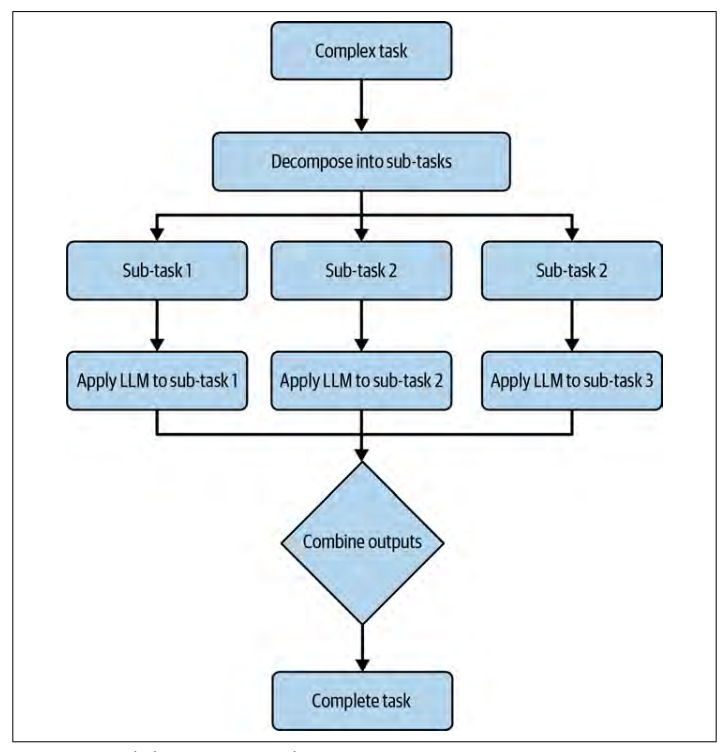


### Prompt Chaining


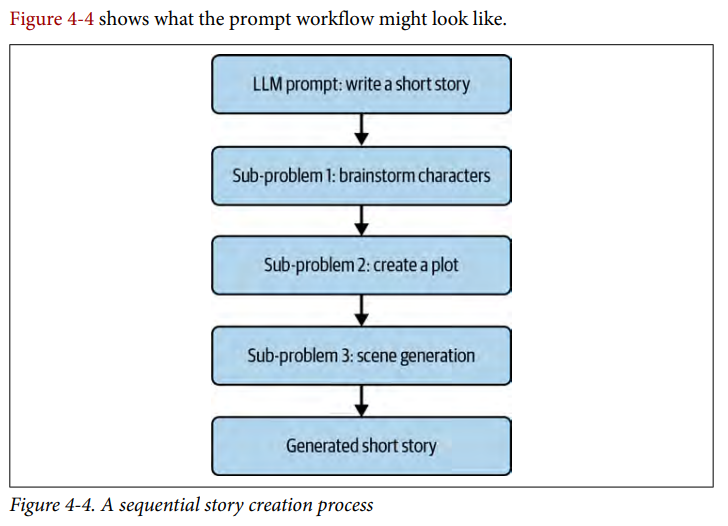

1. Character creation

- character_generation_chain
  - A chain responsible for creating multiple characters given a 'genre'.

2. Plot generation

- plot_generation_chain
  - A chain that will create the plot given the 'characters' and 'genre' keys.

3. Scenes/world building

- scene_generation_chain
  - This chain will generate any missing scenes that were not initially generated from the plot_generation_chain.


In [2]:
from langchain_core.prompts.chat import ChatPromptTemplate
character_generation_prompt = ChatPromptTemplate.from_template(
    """I want you to brainstorm three to five characters for my short story. The
 genre is {genre}. Each character must have a Name and a Biography.
 You must provide a name and biography for each character, this is very
 important!
 ---
 Example response:
 Name: CharWiz, Biography: A wizard who is a master of magic.
 Name: CharWar, Biography: A warrior who is a master of the sword.
 ---
 Characters: """
)

plot_generation_prompt = ChatPromptTemplate.from_template(
    """Given the following characters and the genre, create an effective
 plot for a short story:
 Characters:
 {characters}
 ---
 Genre: {genre}
 ---
 Plot: """
)

scene_generation_plot_prompt = ChatPromptTemplate.from_template(
    """Act as an effective content creator.
 Given multiple characters and a plot, you are responsible for
 generating the various scenes for each act.
 You must decompose the plot into multiple effective scenes:
 ---
 Characters:
 {characters}
 ---
 Genre: {genre}
 ---
 Plot: {plot}
 ---
 Example response:
 Scenes:
 Scene 1: Some text here.
 Scene 2: Some text here.
 Scene 3: Some text here.
 ----
 Scenes:
 """
)

In [3]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
# Create the chat model:
model = ChatOpenAI(model="gpt-3.5-turbo-16k")
# Create the subchains:
character_generation_chain = (character_generation_prompt
                              | model
                              | StrOutputParser())
plot_generation_chain = (plot_generation_prompt
                         | model
                         | StrOutputParser())
scene_generation_plot_chain = (scene_generation_plot_prompt
                               | model
                               | StrOutputParser())

In [4]:
from langchain_core.runnables import RunnableParallel
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

master_chain = (
    {"characters": character_generation_chain, "genre":
     RunnablePassthrough()}
    | RunnableParallel(
        characters=itemgetter("characters"),
        genre=itemgetter("genre"),
        plot=plot_generation_chain,
    )
    | RunnableParallel(
        characters=itemgetter("characters"),
        genre=itemgetter("genre"),
        plot=itemgetter("plot"),
        scenes=scene_generation_plot_chain,
    )
)
story_result = master_chain.invoke({"genre": "Fantasy"})
print(story_result)

{'characters': "1. Name: Aria Shadowheart\n   Biography: Aria is a young and talented sorceress who was raised in a secluded village in the enchanted forest. She possesses an innate connection to nature and can manipulate the elements with ease. Aria's calm demeanor and gentle nature belie her immense power, making her a force to be reckoned with in the world of magic.\n\n2. Name: Draven Blackthorn\n   Biography: Draven is a brooding and mysterious elf who hails from the ancient city of Eldoria. He is a skilled rogue, known for his stealth and agility. Draven's troubled past has hardened him, causing him to become a lone wolf, always on the fringes of society. With his exceptional combat skills and expertise in thievery, he is a formidable presence in the realm of fantasy.\n\n3. Name: Evangeline Frostwind\n   Biography: Evangeline is a wise and ancient ice mage who has lived for centuries in the frozen tundra of Frostholm. She is revered as the guardian of the icy realm, wielding her m

In [5]:
# Extracting the scenes using .split('\n') and removing empty strings:
scenes = [scene for scene in story_result["scenes"].split("\n") if scene]

generated_scenes = []

previous_scene_summary = ""

character_script_prompt = ChatPromptTemplate.from_template(
    template="""Given the following characters: {characters} and the genre:
 {genre}, create an effective character script for a scene.
 You must follow the following principles:
 - Use the Previous Scene Summary: {previous_scene_summary} to avoid
 repeating yourself.
 - Use the Plot: {plot} to create an effective scene character script.
 - Currently you are generating the character dialogue script for the
 following scene: {scene}
 ---
 Here is an example response:
 SCENE 1: ANNA'S APARTMENT
 (ANNA is sorting through old books when there is a knock at the door.
 She opens it to reveal JOHN.)
 ANNA: Can I help you, sir?
 JOHN: Perhaps, I think it's me who can help you. I heard you're
 researching time travel.
 (Anna looks intrigued but also cautious.)
 ANNA: That's right, but how do you know?
 JOHN: You could say... I'm a primary source.
 ---
 SCENE NUMBER: {index}
 """,
)

In [6]:
summarize_prompt = ChatPromptTemplate.from_template(
    template="""Given a character script, create a summary of the scene.
 Character script: {character_script}""",
)

In [7]:
# Loading a chat model:
model = ChatOpenAI(model='gpt-3.5-turbo-16k')

# Create the LCEL chains:
character_script_generation_chain = (
    {
        "characters": RunnablePassthrough(),
        "genre": RunnablePassthrough(),
        "previous_scene_summary": RunnablePassthrough(),
        "plot": RunnablePassthrough(),
        "scene": RunnablePassthrough(),
        "index": RunnablePassthrough(),
    }
    | character_script_prompt
    | model
    | StrOutputParser()
)

summarize_chain = summarize_prompt | model | StrOutputParser()

In [8]:
# You might want to use tqdm here to track the progress,
# or use all of the scenes:
for index, scene in enumerate(scenes[0:3]):
    # # Create a scene generation:
    scene_result = character_script_generation_chain.invoke(
        {
            "characters": story_result["characters"],
            "genre": "fantasy",
            "previous_scene_summary": previous_scene_summary,
            "index": index,
        }
    )

    # Store the generated scenes:
    generated_scenes.append(
        {"character_script": scene_result, "scene": scenes[index]}
    )
    # If this is the first scene then we don't have a
    # previous scene summary:
    if index == 0:
        previous_scene_summary = scene_result
    else:
        # If this is the second scene or greater then
        # we can use and generate a summary:
        summary_result = summarize_chain.invoke(
            {"character_script": scene_result}
        )
        previous_scene_summary = summary_result

print(generated_scenes)

[{'character_script': "SCENE 1: THE ENCHANTED FOREST\n\n(Aria, Draven, Evangeline, Lyra, and Orion are gathered around a campfire, discussing their next move in their quest to defeat the evil sorcerer.)\n\nARIA: We need to come up with a plan to infiltrate the sorcerer's lair. His dark magic is spreading, and innocent lives are at stake.\n\nDRIVEN: I suggest we use my stealth skills to sneak into the lair unnoticed. I can scout the area and gather information on the sorcerer's defenses.\n\nEVANGELINE: While Draven does that, I can create a barrier of ice around the lair to protect us from any magical attacks. My frost spells will freeze our enemies in their tracks.\n\nLYRA: And I'll provide cover fire with my pyrokinetic abilities. I can summon flames and create distractions to keep the sorcerer's minions at bay.\n\nORION: I will stand guard outside the lair, protecting our backs. My swordsmanship and impenetrable armor will ensure no enemy gets through.\n\nARIA: Excellent. Once Draven

### Document Chains


Let’s imagine that before accepting your generated story, the local publisher has
requested that you provide a summary based on all of the character scripts. This is a
good use case for document chains because you need to provide an LLM with a large
amount of text that wouldn’t fit within a single LLM request due to the context length
restrictions.


In [9]:
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
import pandas as pd

df = pd.DataFrame(generated_scenes)

print(df)

                                    character_script  \
0  SCENE 1: THE ENCHANTED FOREST\n\n(Aria, Draven...   
1  SCENE 1: THE ENCHANTED FOREST\n\n(The group is...   
2  SCENE 2: ENCHANTED FOREST CAMPFIRE\n\n(The gro...   

                                               scene  
0  Scene 1: Aria Shadowheart communing with natur...  
1  Scene 2: Draven Blackthorn, brooding and haunt...  
2  Scene 3: Aria and Draven journey through treac...  


In [10]:
all_character_script_text = "\n".join(df.character_script.tolist())

print(all_character_script_text)

SCENE 1: THE ENCHANTED FOREST

(Aria, Draven, Evangeline, Lyra, and Orion are gathered around a campfire, discussing their next move in their quest to defeat the evil sorcerer.)

ARIA: We need to come up with a plan to infiltrate the sorcerer's lair. His dark magic is spreading, and innocent lives are at stake.

DRIVEN: I suggest we use my stealth skills to sneak into the lair unnoticed. I can scout the area and gather information on the sorcerer's defenses.

EVANGELINE: While Draven does that, I can create a barrier of ice around the lair to protect us from any magical attacks. My frost spells will freeze our enemies in their tracks.

LYRA: And I'll provide cover fire with my pyrokinetic abilities. I can summon flames and create distractions to keep the sorcerer's minions at bay.

ORION: I will stand guard outside the lair, protecting our backs. My swordsmanship and impenetrable armor will ensure no enemy gets through.

ARIA: Excellent. Once Draven returns with the information, we'll 

In [11]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1500, chunk_overlap=200
)

docs = text_splitter.create_documents([all_character_script_text])

chain = load_summarize_chain(llm=model, chain_type="map_reduce")

summary = chain.invoke(docs)

print(summary['output_text'])

Aria, Draven, Evangeline, Lyra, and Orion meet in the Enchanted Forest to discuss their plan to defeat an evil sorcerer. Draven gathers information, Evangeline creates an ice barrier, Lyra provides cover fire, and Orion stands guard. They will then devise a strategy to defeat the sorcerer and restore peace to the realm.


##### Stuff


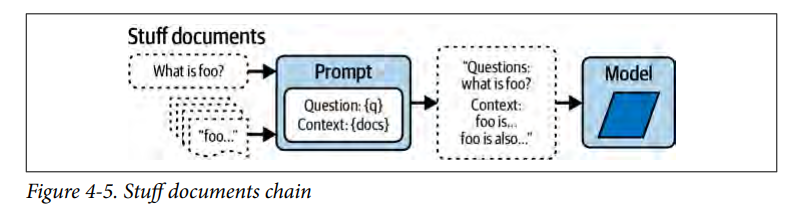

process of integrating multiple documents into a single LLM request.


##### Refine


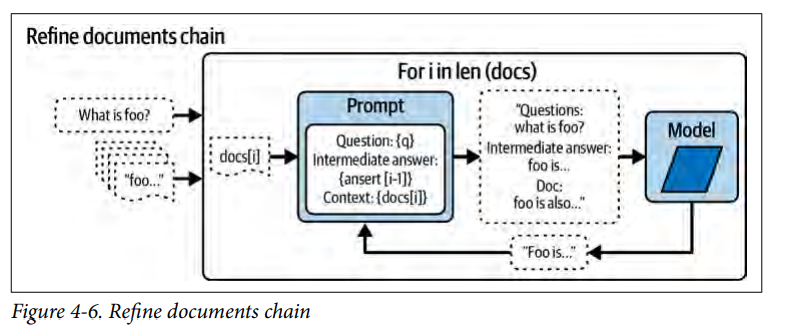

During each loop, it combines the current output (derived from the LLM) with the current document


##### Map Reduce


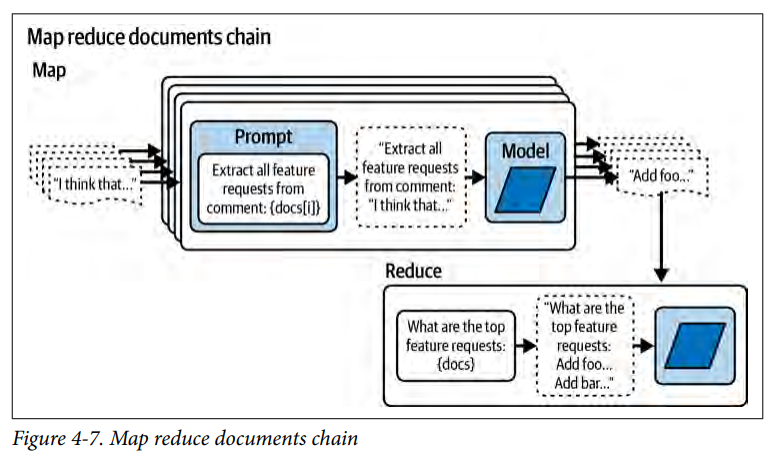

1. starts with an LLM chain to each separate document (a process known as the Map step), interpreting the resulting output as a newly generated document.
2. all these newly created documents are introduced to a distinct combine
   documents chain to formulate a singular output (a process referred to as the Reduce
   step).


##### Map Re-rank


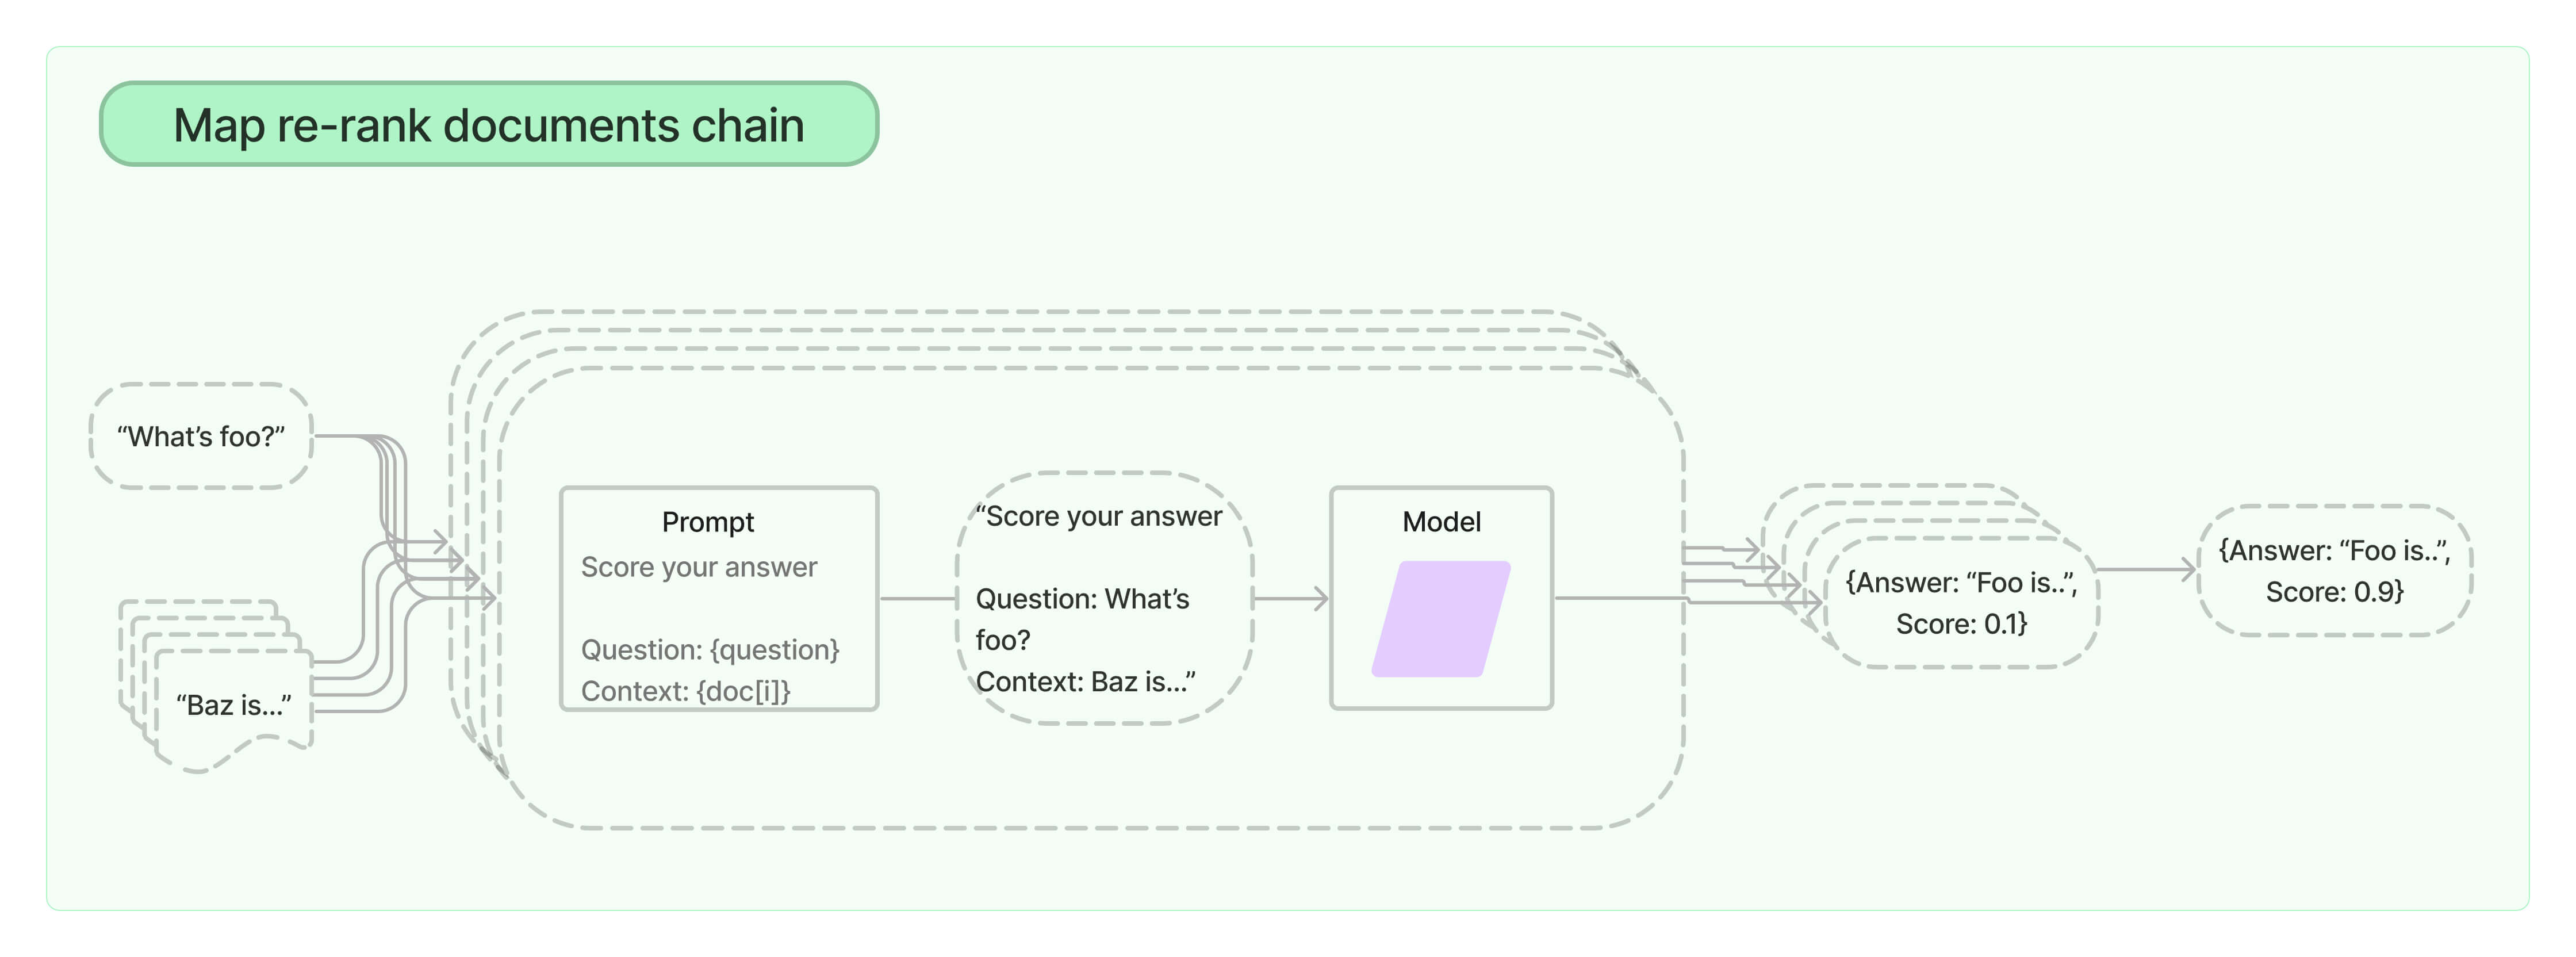


There is also map re-rank, which operates by executing an initial prompt on each
document. This not only strives to fulfill a given task but also assigns a confidence score reflecting the certainty of its answer. The response with the highest confidence score is then selected and returned.


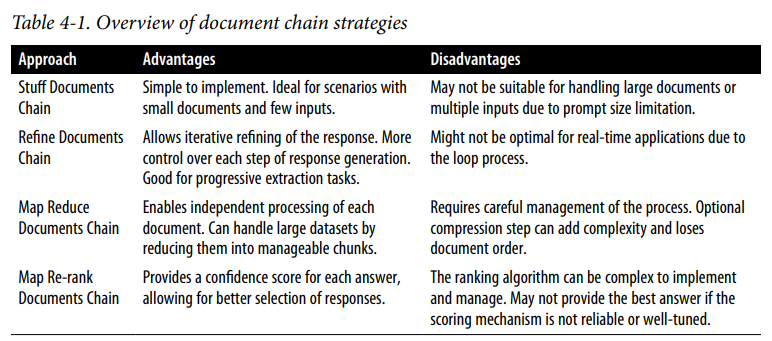


https://python.langchain.com/v0.1/docs/use_cases/summarization/#use-case


### itemgetter and Dictionary Key Extraction


In [1]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough
chain = RunnablePassthrough() | {
    "genre": itemgetter("genre"),
}
chain.invoke({"genre": "fantasy"})

{'genre': 'fantasy'}

1. RunnablePassThrough function simply passes any inputs directly to the next
   step
2. itemgetter extract keys from the previous step


### RunnableLambda


- use lambda or RunnableLambda functions within an LCEL chain
  to manipulate previous dictionary values.
- A lambda is an anonynous function


In [2]:
from langchain_core.runnables import RunnableLambda

chain = RunnablePassthrough() | {
    "genre": itemgetter("genre"),
    "upper_case_genre": lambda x: x["genre"].upper(),
    "lower_case_genre": RunnableLambda(lambda x: x["genre"].lower()),
}
chain.invoke({"genre": "fantasy"})

{'genre': 'fantasy',
 'upper_case_genre': 'FANTASY',
 'lower_case_genre': 'fantasy'}

### RunnableParallel


In [3]:
from langchain_core.runnables import RunnableParallel

# 1. using a dictionary
master_chain = RunnablePassthrough() | {
    "genre": itemgetter("genre"),
    "upper_case_genre": lambda x: x["genre"].upper(),
    "lower_case_genre": RunnableLambda(lambda x: x["genre"].lower()),
}

# 2. using RunnableParallel
master_chain_two = RunnablePassthrough() | RunnableParallel(
    genre=itemgetter("genre"),
    upper_case_genre=lambda x: x["genre"].upper(),
    lower_case_genre=RunnableLambda(lambda x: x["genre"].lower()),
)

story_result = master_chain.invoke({"genre": "Fantasy"})
print(story_result)
story_result = master_chain_two.invoke({"genre": "Fantasy"})
print(story_result)

{'genre': 'Fantasy', 'upper_case_genre': 'FANTASY', 'lower_case_genre': 'fantasy'}
{'genre': 'Fantasy', 'upper_case_genre': 'FANTASY', 'lower_case_genre': 'fantasy'}


### Structuring LCEL Chains


In LCEL you must ensure that the first part of your LCEL chain is a runnable type.


In [24]:
from langchain_core.prompts.chat import ChatPromptTemplate
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

bad_first_input = {
    "film_required_age": 18,
}

prompt = ChatPromptTemplate.from_template(
    "Generate a film title, the age is {film_required_age}"
)

# This will error:
bad_chain = bad_first_input | prompt

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'int'>

A Python dictionary with a value of 18 will not create a runnable LCEL chain.


In [25]:
# All of these chains enforce the runnable interface:
first_good_input = {"film_required_age": itemgetter("film_required_age")}

# Creating a dictionary within a RunnableLambda:
second_good_input = RunnableLambda(lambda x: {"film_required_age":
                                              x["film_required_age"]})

third_good_input = RunnablePassthrough()

fourth_good_input = {"film_required_age": RunnablePassthrough()}

# You can also create a chain starting with RunnableParallel(...)
first_good_chain = first_good_input | prompt
second_good_chain = second_good_input | prompt
third_good_chain = third_good_input | prompt
fourth_good_chain = fourth_good_input | prompt

first_good_chain.invoke({
    "film_required_age": 18
})

second_good_chain.invoke({
    "film_required_age": 18
})

third_good_chain.invoke({
    "film_required_age": 18
})

fourth_good_chain.invoke({
    "film_required_age": 18
})

ChatPromptValue(messages=[HumanMessage(content="Generate a film title, the age is {'film_required_age': 18}")])